Model Order Selection for Neural Data
=====================================

**Name**: \[YAO ZHAO\]

**Net ID**: \[yz10912\]

**Attribution**: This notebook is a slightly adapted version of the [model order selection lab assignment](https://github.com/sdrangan/introml/blob/master/unit04_model_sel/lab_neural_partial.ipynb) by Prof. Sundeep Rangan.

Machine learning is a key tool for neuroscientists to understand how sensory and motor signals are encoded in the brain. In addition to improving our scientific understanding of neural phenomena, understanding neural encoding is critical for brain machine interfaces. In this notebook, you will use model selection for performing some simple analysis on real neural signals.

Loading the data
----------------

The data in this lab comes from neural recordings described in:

<a href="http://jn.physiology.org/content/106/2/764.short"> Stevenson, Ian H., et al. “Statistical assessment of the stability of neural movement representations.” Journal of neurophysiology 106.2 (2011): 764-774</a>

Neurons are the basic information processing units in the brain. Neurons communicate with one another via *spikes* or *action potentials* which are brief events where voltage in the neuron rapidly rises then falls. These spikes trigger the electro-chemical signals between one neuron and another. In this experiment, the spikes were recorded from 196 neurons in the primary motor cortex (M1) of a monkey using an electrode array implanted onto the surface of a monkey's brain. During the recording, the monkey performed several reaching tasks and the position and velocity of the hand was recorded as well.

The goal of the experiment is to try to *read the monkey's brain*: That is, predict the hand motion from the neural signals from the motor cortex.

We first load the key packages.

In [45]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pickle

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split, KFold

The full data is available on the CRCNS website <a href="http://crcns.org/data-sets/movements/dream" class="uri">http://crcns.org/data-sets/movements/dream</a>. However, the raw data files can be quite large. To make the lab easier, the [Kording lab](http://kordinglab.com/) at UPenn has put together an excellent [repository](https://github.com/KordingLab/Neural_Decoding) where they have created simple pre-processed versions of the data. You can download the file `example_data_s1.pickle` from the [Dropbox link](https://www.dropbox.com/sh/n4924ipcfjqc0t6/AADOv9JYMUBK1tlg9P71gSSra/example_data_s1.pickle?dl=0). Alternatively, you can directly run the following command. This may take a little while to download since the file is 26 MB.

In [90]:
!wget 'https://www.dropbox.com/sh/n4924ipcfjqc0t6/AADOv9JYMUBK1tlg9P71gSSra/example_data_s1.pickle?dl=1' -O example_data_s1.pickle

--2025-02-28 04:07:44--  https://www.dropbox.com/sh/n4924ipcfjqc0t6/AADOv9JYMUBK1tlg9P71gSSra/example_data_s1.pickle?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.65.18, 2620:100:6021:18::a27d:4112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.65.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.dropbox.com/scl/fo/h6u1zn1txqrgf0eyko8xu/AAt1EkEOGQAKdmOiyCSxdGY/example_data_s1.pickle?rlkey=wnriqis4p52evt38btpmijane&dl=1 [following]
--2025-02-28 04:07:45--  https://www.dropbox.com/scl/fo/h6u1zn1txqrgf0eyko8xu/AAt1EkEOGQAKdmOiyCSxdGY/example_data_s1.pickle?rlkey=wnriqis4p52evt38btpmijane&dl=1
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc63012e5baeaf5542fb779a4fd2.dl.dropboxusercontent.com/cd/0/inline/Ck9zy1rjMFtX8_ABni1DuxZfkLBhijGp8Pujw4L-LYJeFEbzIPuaValXDodEQEgq-OCLjMLohNPaPJD92np4QVt8cr4Lt1scY_0Az1TrtVm3dEDdyIysuxjinAb9VVSEvz0/file?dl=1# [follo

The file is a *pickle* data structure, which uses the Python package `pickle` to serialize Python objects into data files. Once you have downloaded the file, you can run the following command to retrieve the data from the pickle file.

In [47]:
with open('example_data_s1.pickle', 'rb') as fp:
    X,y = pickle.load(fp)

The matrix `X` is matrix of spike counts from different neurons, where `X[i,j]` is the number of spikes from neuron `j` in time bin `i`.

The matrix `y` has two columns:

-   `y[i,0] =` velocity of the monkey's hand in the x-direction in time bin `i`
-   `y[i,1] =` velocity of the monkey's hand in the y-direction in time bin `i`

Our goal will be to predict `y` from `X`.

Each time bin represent `tsamp=0.05` seconds of time. Using `X.shape` and `y.shape`, we can compute and print:

-   `nt =` the total number of time bins
-   `nneuron =` the total number of neurons
-   `nout =` the total number of output variables to track = number of columns in `y`
-   `ttotal =` total time of the experiment is seconds.

In [48]:
tsamp = 0.05  # sampling time in seconds

nt, nneuron = X.shape
nout = y.shape[1]
ttotal = nt*tsamp

print('Number of neurons = %d' % nneuron)
print('Number of time samples = %d' % nt)
print('Number of outputs = %d' % nout)
print('Total time (secs) = %f' % ttotal)

Number of neurons = 52
Number of time samples = 61339
Number of outputs = 2
Total time (secs) = 3066.950000


Then, we can plot the velocity against time, for each direction, for the first 1000 samples:

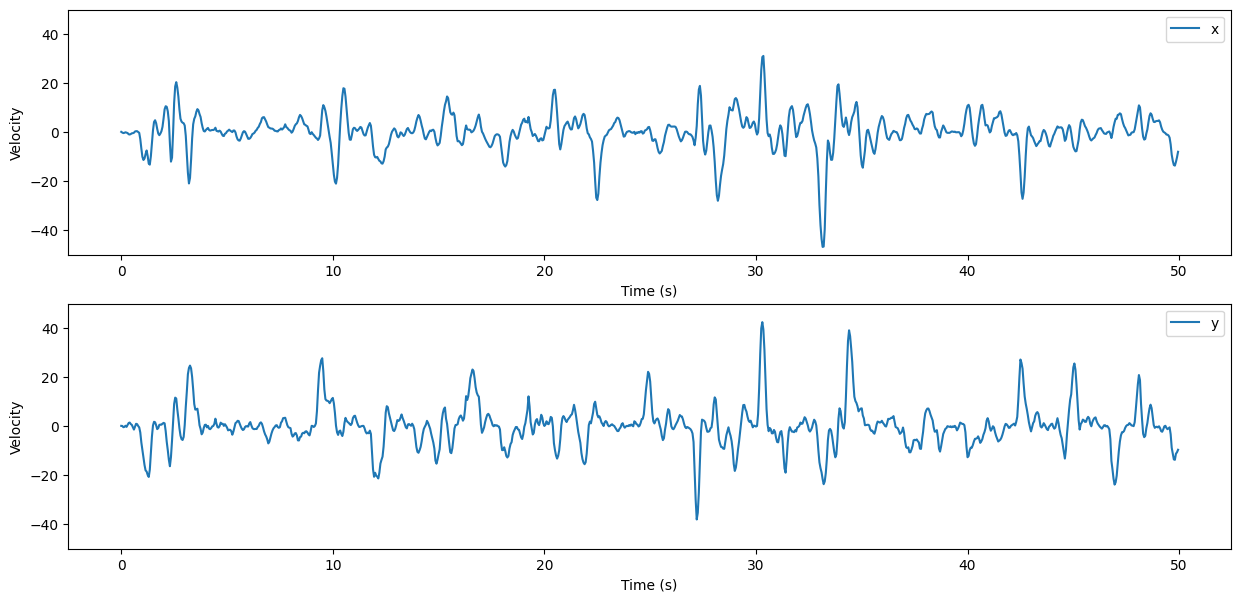

In [49]:
t_cutoff = 1000
directions = ['x', 'y']

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15,7))
for n in range(nout):
  sns.lineplot(x=np.arange(0, t_cutoff)*tsamp, y=y[0:t_cutoff, n], label=directions[n], ax=axes[n]);

  axes[n].set_ylabel("Velocity")
  axes[n].set_xlabel("Time (s)")
  axes[n].set_ylim(-50,50)

We can also “zoom in” on a small slice of time in which the monkey is moving the hand, and see the neural activity at the same time.

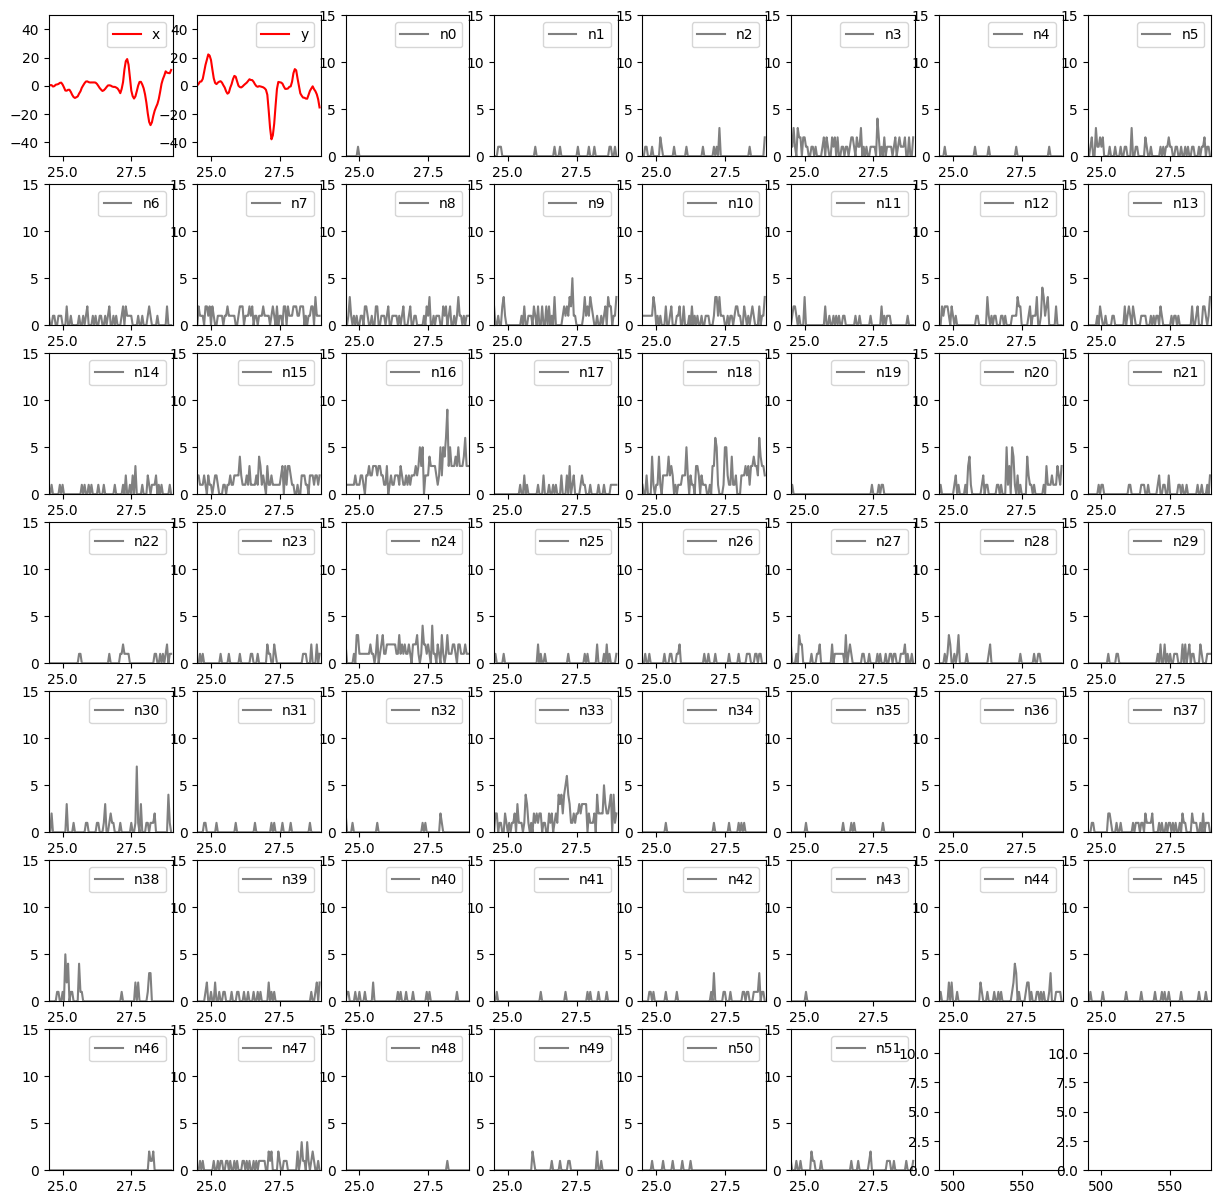

In [50]:
t_start = 490
t_end = 580

fig, axes = plt.subplots(nrows=7, ncols=8, figsize=(15,15))

# Setting the range for all axes
plt.setp(axes, xlim=(t_start, t_end), ylim=(0,12));

for n in range(nout):
  sns.lineplot(x=np.arange(t_start, t_end)*tsamp, y=y[t_start:t_end, n], ax=axes[n//2,n%2], color='red', label=directions[n])
  plt.setp(axes[n//2,n%2], xlim=(t_start*tsamp, t_end*tsamp), ylim=(-50, +50));

for n in range(nneuron):
  sns.lineplot(x=np.arange(t_start, t_end)*tsamp, y=X[t_start:t_end, n], ax=axes[(n+2)//8,(n+2)%8], label="n%d" % n, color='grey')
  plt.setp(axes[(n+2)//8,(n+2)%8], xlim=(t_start*tsamp, t_end*tsamp), ylim=(0, +15));


Fitting a linear model
----------------------

Let’s first try a linear regression model to fit the data.

To start, we will split the data into a training set and a test set. We’l fit the model on the training set and then use the test set to estimate the model performance on new, unseen data.

**To shuffle or not to shuffle?**

The `train_test_split` function has an optional `shuffle` argument.

-   If you use `shuffle=False`, then `train_test_split` will take the first part of the data as the training set and the second part of the data as the test set, according to the ratio you specify in `test_size` or `train_size`.
-   If you use `shuffle=True`, then `train_test_split` will first randomly shuffle the data. Then, it will take the first part of the *shuffled* data as the training set and the second part of the *shuffled* data as the test set, according to the ratio you specify in `test_size` or `train_size`.

According to the function [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html), by default, `shuffle` is `True`:

> **shuffle: bool, default=True**
>
> Whether or not to shuffle the data before splitting. If shuffle=False then stratify must be None.

so if you do not specify anything related to `shuffle`, your data will be randomly shuffled before it is split into training and test data.

Under what conditions should you shuffle data? Suppose your dataset includes samples of a medical experiment on 1000 subjects, and the first 500 samples in the data are from male subjects while the second 500 samples are from female subjects. If you set `shuffle=False`, then your training set would have a much higher proportion of male subjects than your test set (with the specific numbers depending on the ratio you specify).

On the other hand, suppose your dataset includes stock prices at closing time, with each sample representing a different date (in order). If you allow `train_test_split` to shuffle the data, then your model will be allowed to “learn” stock prices using prices from the day *after* the one it is trying to predict! Obviously, your model won’t be able to learn from future dates in production, so it shouldn’t be allowed to in the evaluation stage, either. (Predicting the past using the future is considered a type of data leakage.)

With this in mind, it is usually inappropriate to shuffle time series data when splitting it up into smaller sets for training, validation, or testing.

(There are more sophisticated ways to handle splitting time series data, but for now, splitting it up the usual way, just without shuffling first, will suffice.)

Given the discussion above, use the `train_test_split` function to split the data into training and test sets, but with no shuffling. Let `Xtr,ytr` be the training data set and `Xts,yts` be the test data set. Use `test_size=0.33` so 1/3 of the data is used for evaluating the model performance.

In [59]:
# TODO: Split data intro training and test sets
# Xtr ...
from sklearn.model_selection import train_test_split
Xtr, Xts, ytr, yts = train_test_split(X, y, test_size=0.33, shuffle=False)

Now, fit a linear regression on the training data `Xtr,ytr`. Make a prediction `yhat` using the test data, `Xts`. Compare `yhat` to `yts` to measure `rsq`, the R2 value. Use the sklearn `r2_score` method.

In [60]:
# TODO: Fit a linear model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Fit the linear regression model using training data
model = LinearRegression()
model.fit(Xtr, ytr)

# Make predictions on the test set
yhat = model.predict(Xts)

# Compute the R² score
rsq = r2_score(yts, yhat)


Print the `rsq` value. You should get `rsq` of around `0.45`.

In [61]:
rsq

0.4499831346553009

It is useful to plot the predicted vs. actual values. Use the test data for this visualization. Create a scatter plot of predicted values ($\hat{y}$) on the vertical axis, and actual values ($y$) on the horizontal axis. Since we have two predicted values for each sample - the velocity in the X direction and the velocity in the Y direction - you should make two subplots,

-   one of predicted X direction vs. actual X direction,
-   one of predicted Y direction vs. actual Y direction

Make sure both axes use the same scale (the range of the vertical axis should be the same as the range of the horizontal axis) *and* that all subplots use the same scale. Label each axes, and each plot (indicate which plot shows the velocity in the X direction and which shows the velocity in the Y direction!)

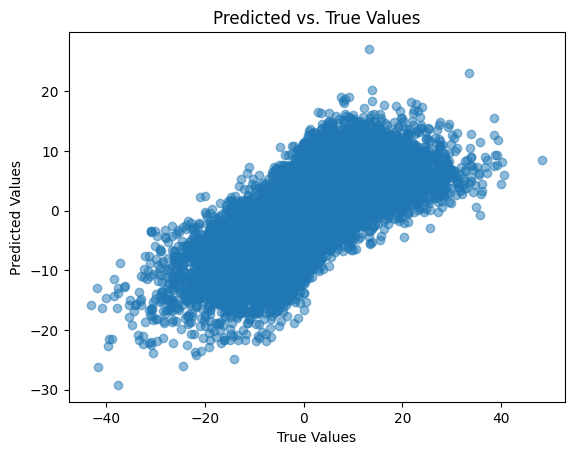

In [62]:
# TODO: Predicted values vs true values visualization
import matplotlib.pyplot as plt

plt.scatter(yts, yhat, alpha=0.5)
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Predicted vs. True Values")
plt.show()


It can also be useful to visualize the actual and predicted values over time, for a slice of time. Use the test data for this visualization. Create two subplots, both with time on the horizontal axis, but only including *the first 1000 rows* (50 seconds) in the data. On the vertical axis,

-   for one subplot: show the actual X direction as a line of one color, and the predicted X direction as a line of another color.
-   for the second subplot: show the actual Y direction as a line of one color, and the predicted Y direction as a line of another color.

Make sure to carefully label each axis (including units on the time axis!), and label the data series (i.e. which color is the actual value and which is the predicted value).

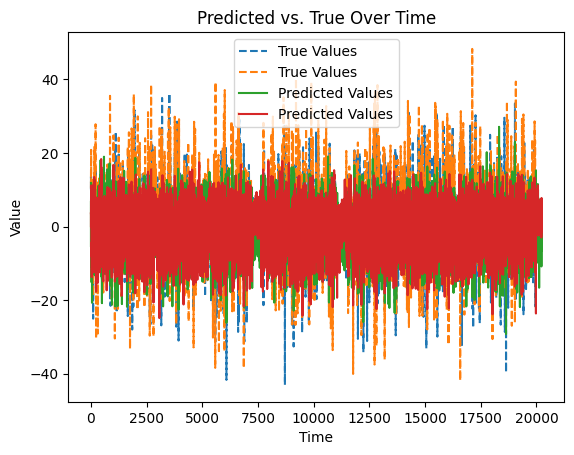

In [63]:
# TODO: Predicted and true values over time visualization
import matplotlib.pyplot as plt

plt.plot(yts, label="True Values", linestyle="dashed")
plt.plot(yhat, label="Predicted Values")
plt.xlabel("Time")
plt.ylabel("Value")
plt.title("Predicted vs. True Over Time")
plt.legend()
plt.show()



[link text](https://)Comment on this plot - does the model predict the hand velocity well?

The model captures some structure in hand velocity but fails to predict sharp changes accurately. A more sophisticated approach may be needed for better predictions.

Fitting a model with delay
--------------------------

One way we can improve the model accuracy is to add features using delayed version of the existing features.

Specifically, the model we used above tries to predict velocity in direction $k$ at time $i$ using

$$\hat{y}_{i,k} = w_{k,0} + \sum_{d=1}^{\text{nneuron}} w_{k,d} X_{i,d}  $$

In this model, $\hat{y}_{i,k}$ at the $i$th time bin was only dependent on $X_i$, the number of spikes of each neuron in time bin $i$. In signal processing, this is called a *memoryless* model.

However, in many physical systems, such as those that arise in neuroscience, there is a delay between the inputs and outputs. To model this effect, we could add additional features to each row of data, representing the number of spikes of each neuron in the *previous* row. Then, the output at time $i$ would be modeled as the effect of the neurons firing in time $i$ *and* the effect of the neurons firing in time $i-1$.

We wouldn’t be able to use data from the past for the first row of data, since we don’t *have* data about neurons firing in the previous time step. But we can drop that row. If our original data matrix had `nt` rows and `nneuron` columns, our data matrix with delayed features would have `nt - 1` rows and `nneuron + 1 x nneuron` columns. (The first `nneuron` columns represent the number of spikes in each neuron for the current time, the next `nneuron` columns represent the number of spikes in each neuron for the previous time.)

Furthermore, we can “look back” any number of time steps, so that the output at time $i$ is modeled as the effect of the neurons firing in time $i$, the neurons firing in time $i-1$, ..., all the way up to the effect of the neurons firing in time $i- \text{dly}$ (where $\text{dly}$ is the maximum number of time steps we're going to “look back” on). Our data matrix with the additional delayed features would have `nt - dly` rows and `nneuron + dly x nneuron` columns.

Here is a function that accepts `X` and `y` data and a `dly` argument, and returns `X` and `y` with delayed features up to `dly` time steps backward.

In [64]:
def create_dly_data(X,y,dly):
    """
    Create delayed data
    """
    n,p = X.shape
    Xdly = np.zeros((n-dly,(dly+1)*p))
    for i in range(dly+1):
        Xdly[:,i*p:(i+1)*p] = X[dly-i:n-i,:]
    ydly = y[dly:]

    return Xdly, ydly

To convince yourself that this works, try creating a data matrix that includes delayed features one time step back:

In [65]:
X_dly1, y_dly1 = create_dly_data(X, y, 1)

Verify that the dimensions have changed, as expected:

In [66]:
# dimensions of original data matrix
X.shape

(61339, 52)

In [67]:
# dimensions of data matrix with delayed features 1 time step back
X_dly1.shape

(61338, 104)

Check row 0 in the matrix with delayed features, and verify that it is the concatenation of row 1 and row 0 in the original data matrix. (Note that row 0 in the matrix with delayed features corresponds to row 1 in the original data matrix.)

In [68]:
X_dly1[0]

array([0., 0., 1., 1., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 1., 2., 0., 0., 1., 0., 2., 0., 0., 3., 0., 0., 2.,
       2., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 2., 0., 0.,
       2., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0.,
       0., 1.])

In [69]:
np.hstack((X[1], X[0]))

array([0., 0., 1., 1., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 1., 2., 0., 0., 1., 0., 2., 0., 0., 3., 0., 0., 2.,
       2., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 2., 0., 0.,
       2., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0.,
       0., 1.])

In [70]:
y_dly1[0]

array([-0.13949835,  0.11006426])

In [71]:
y[1]

array([-0.13949835,  0.11006426])

Now fit an linear delayed model with `dly=2` delay lags. That is,

-   Create delayed data by calling `create_dly_data` with `dly=2`
-   Split the data (with the extra delay features!) into training and test as before (again, do not shuffle the data, and use a test size of 0.33)
-   Fit the model on the training data
-   Use the model to predict the values for the test data and save the result in `yhat`
-   Measure the R2 score on the test data and save the result in `rsq`

If you did this correctly, you should get a new R2 score around 0.60. This is significantly better than the memoryless model.

In [73]:
# TODO: Fit a linear model with dly=2

# Step 1: Create delayed data with dly=2
dly = 2
Xdly, ydly = create_dly_data(X, y, dly)

# Step 2: Split the delayed data into training and test sets (without shuffling)
Xtr, Xts, ytr, yts = train_test_split(Xdly, ydly, test_size=0.33, shuffle=False)

# Step 3: Fit a linear regression model using training data
model_dly2 = LinearRegression()
model_dly2.fit(Xtr, ytr)

# Step 4: Predict on the test set
yhat = model_dly2.predict(Xts)

# Step 5: Compute the R² score
rsq = r2_score(yts, yhat)


As before, plot the predicted vs. true values, but for the model with `dly=2`, with one subplot for X velocity and one subplot for Y velocity.

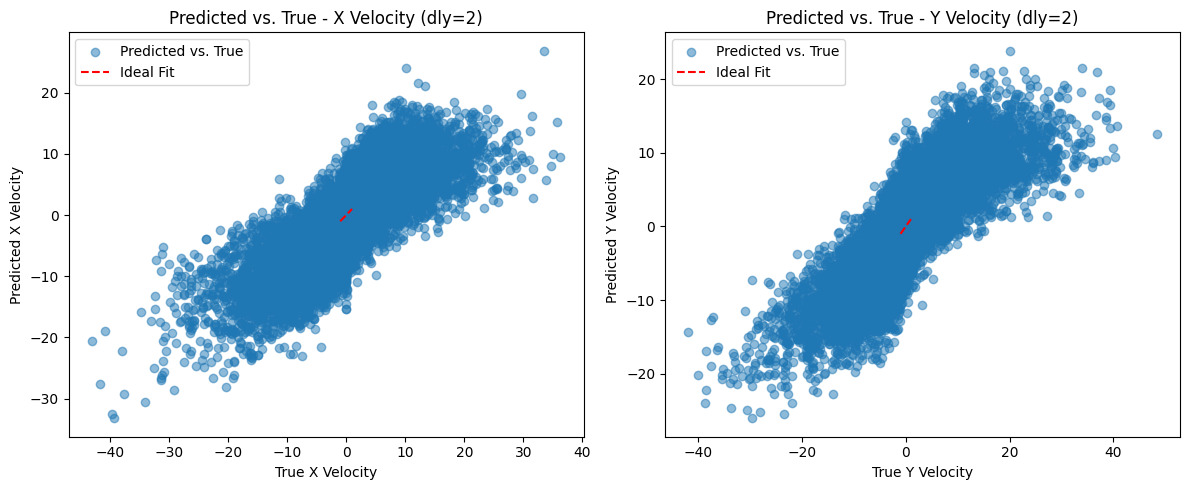

In [75]:
# TODO: Predicted values vs true values visualization with dly=2
import matplotlib.pyplot as plt

# Create subplots for X and Y velocity
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Scatter plot for X velocity
axes[0].scatter(yts[:, 0], yhat[:, 0], alpha=0.5, label="Predicted vs. True")
axes[0].plot([-1, 1], [-1, 1], 'r', linestyle="dashed", label="Ideal Fit")  # Reference line
axes[0].set_xlabel("True X Velocity")
axes[0].set_ylabel("Predicted X Velocity")
axes[0].set_title("Predicted vs. True - X Velocity (dly=2)")
axes[0].legend()

# Scatter plot for Y velocity
axes[1].scatter(yts[:, 1], yhat[:, 1], alpha=0.5, label="Predicted vs. True")
axes[1].plot([-1, 1], [-1, 1], 'r', linestyle="dashed", label="Ideal Fit")  # Reference line
axes[1].set_xlabel("True Y Velocity")
axes[1].set_ylabel("Predicted Y Velocity")
axes[1].set_title("Predicted vs. True - Y Velocity (dly=2)")
axes[1].legend()

plt.tight_layout()
plt.show()



Also as you did before, plot the actual and predicted valuer over time for the first 1000 samples, for the model with `dly=2`. Does the model predict the hand velocity well?

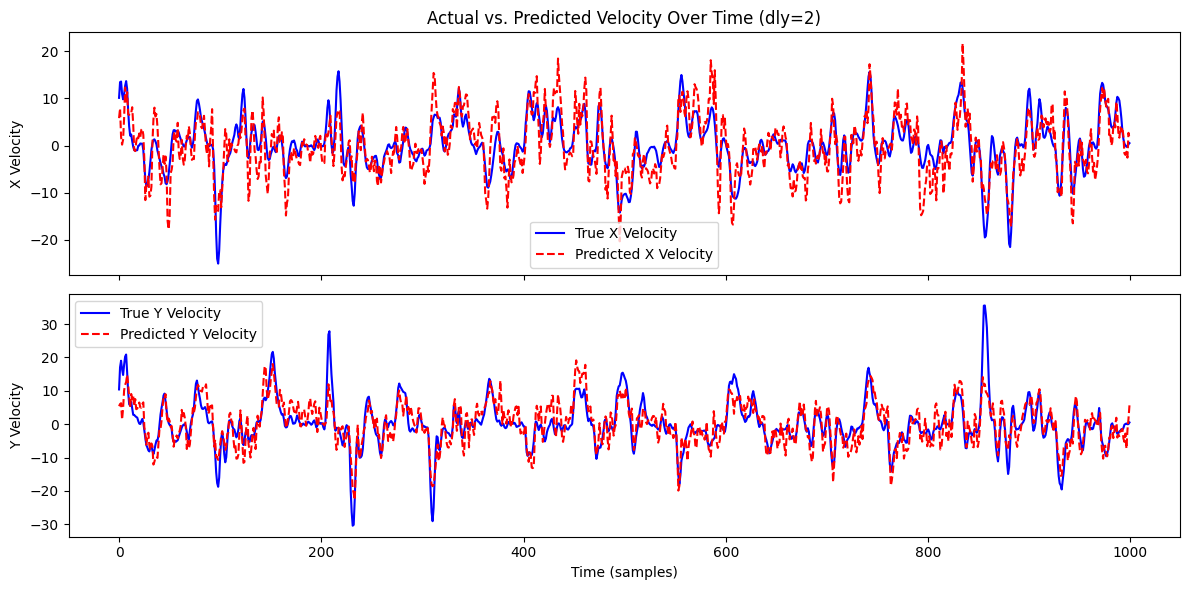

In [76]:
# TODO: Predicted and true values over time visualization with dly=2
# Define time indices for the first 1000 samples
time_indices = np.arange(1000)

# Create a figure with two subplots: one for X velocity, one for Y velocity
fig, axes = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

# Plot for X velocity
axes[0].plot(time_indices, yts[:1000, 0], label="True X Velocity", color='blue')
axes[0].plot(time_indices, yhat[:1000, 0], label="Predicted X Velocity", color='red', linestyle="dashed")
axes[0].set_ylabel("X Velocity")
axes[0].set_title("Actual vs. Predicted Velocity Over Time (dly=2)")
axes[0].legend()

# Plot for Y velocity
axes[1].plot(time_indices, yts[:1000, 1], label="True Y Velocity", color='blue')
axes[1].plot(time_indices, yhat[:1000, 1], label="Predicted Y Velocity", color='red', linestyle="dashed")
axes[1].set_xlabel("Time (samples)")
axes[1].set_ylabel("Y Velocity")
axes[1].legend()

plt.tight_layout()
plt.show()



Selecting the optimal delay with K-fold CV
------------------------------------------

In the previous example, we fixed `dly=2`. We can now select the optimal delay using K-fold cross validation.

Since we have a large number of data samples, it turns out that the optimal model order uses a very high delay. Using the above fitting method, the computations take too long. So, to simplify things, we will just pretend that we have a very limited data set.

We will compute `Xred` and `yred` by taking the first `nred=6000` samples of the data `X` and `y`.

In [77]:
nred = 6000

Xred = X[:nred]
yred = y[:nred]

Note: since we are only using the first 6000 samples to train the model and select the best `dly`, there are plenty of samples left out as the test set. We don’t need to (and shouldn’t) further divide these 6000 samples into training and test sets - we can use all of it for model training and model selection.

We will look at model orders up to `dmax=15`. We will create a delayed data matrix, `Xdly,ydly`, using `create_dly_data` with the reduced data `Xred,yred` and `dly=dmax`.

In [78]:
dmax = 15

Xdly, ydly = create_dly_data(Xred,yred,dmax)

In [79]:
Xdly.shape

(5985, 832)

In [80]:
ydly.shape

(5985, 2)

<!--
::: {.cell .markdown }
Note that we can use `Xdly, ydly` to get a data matrix for any delay *up
to* `dmax`, not only for delay = `dmax`. For example, to get a data
matrix with delay = 1:
:::

::: {.cell .code }
```python
dtest = 1
X_dtest = Xdly[:,:(dtest+1)*nneuron]
X_dtest.shape
```
:::
-->

We are going to use K-fold CV with `nfold=10` to find the optimal delay, for all the values of delay in `dtest_list`:

In [81]:
dtest_list = np.arange(0, dmax+1)
nd = len(dtest_list)

print(dtest_list)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]


You can refer to the example in the “Model order selection” section of the demo notebook. But, make sure to use `shuffle=False` in your `KFold` object, since for this example it would be inappropriate to shuffle the data.

In [82]:
# TODO: Use K-fold CV to select dly

from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import numpy as np

# Number of folds
nfold = 10

# Create a KFold object
kf = KFold(n_splits=nfold, shuffle=True, random_state=42)

# Initialize a matrix Rsq to hold values of the R^2 across the model orders and folds
Rsq = np.zeros((len(dtest_list), nfold))

# Loop over the folds
for i, (idx_tr, idx_val) in enumerate(kf.split(Xdly)):

    for it, dtest in enumerate(dtest_list):
        # Select only the columns corresponding to the `dtest+1` most recent times
        X_dtest = Xdly[:, :dtest+1]  # Assuming Xdly is structured with time-shifted columns

        # Split into training and validation sets
        Xtr, ytr = X_dtest[idx_tr], ydly[idx_tr]
        Xval, yval = X_dtest[idx_val], ydly[idx_val]

        # Fit linear regression on training data
        model = LinearRegression()
        model.fit(Xtr, ytr)

        # Predict on validation set
        y_pred = model.predict(Xval)

        # Measure the R² on validation data and store in the matrix Rsq
        Rsq[it, i] = r2_score(yval, y_pred)

# Compute the mean R² for each delay value
mean_Rsq = Rsq.mean(axis=1)

# Select the best dly with the highest mean R²
best_dly = dtest_list[np.argmax(mean_Rsq)]


Write code to find the delay that has the best mean validation R2. Get the best delay according to the “best R2” rule, and save it in `d_opt`.

In [83]:
# TODO: Use K-fold CV (continued)
# Compute the mean R² for each delay value across folds
mean_Rsq = Rsq.mean(axis=1)

# Select the best delay (d_opt) with the highest mean R²
d_opt = dtest_list[np.argmax(mean_Rsq)]

Now write code to find the best delay using the one SE rule (i.e. find the simplest model whose validation R2 is within one SE of the model with the best R2). Get the best delay according to the “one SE rule”, and save it in `d_one_se`.

In [84]:
# TODO: Use K-fold CV (continued)
import numpy as np

# Compute mean and standard error of R² for each delay
mean_Rsq = Rsq.mean(axis=1)
se_Rsq = Rsq.std(axis=1) / np.sqrt(nfold)  # Standard error: std deviation / sqrt(n)

# Find the best R² and its corresponding delay
best_idx = np.argmax(mean_Rsq)
best_Rsq = mean_Rsq[best_idx]

# One SE threshold
threshold = best_Rsq - se_Rsq[best_idx]

# Find the simplest model (smallest dly) within one SE of the best R²
d_one_se = dtest_list[np.where(mean_Rsq >= threshold)[0][0]]

Plot the mean and standard error of the validation R2 values for each model (each delay value) as a function of the delay. Use a `plt.errorbar` plot, as shown in the “Model selection using 1-SE rule” section of the demo notebook. Label each axes.

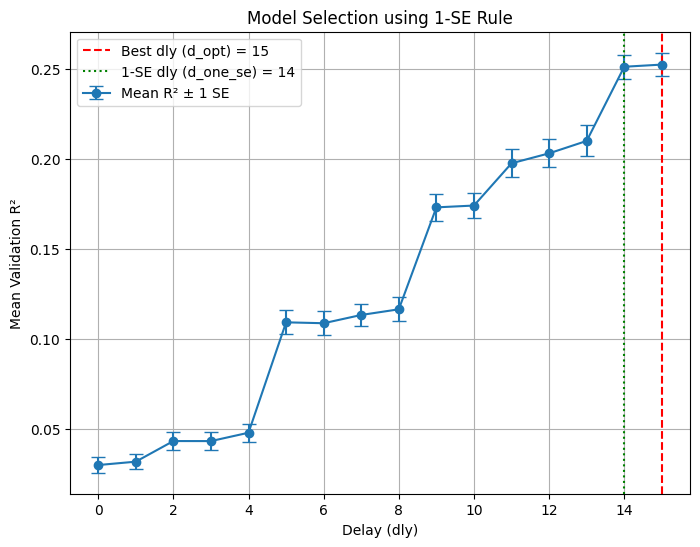

In [85]:
# TODO: Visualize mean and SE of R2 across folds for each dly

import matplotlib.pyplot as plt

# Compute mean and standard error of R² for each delay
mean_Rsq = Rsq.mean(axis=1)
se_Rsq = Rsq.std(axis=1) / np.sqrt(nfold)  # Standard error: std deviation / sqrt(n)

# Plot mean R² with error bars
plt.figure(figsize=(8, 6))
plt.errorbar(dtest_list, mean_Rsq, yerr=se_Rsq, fmt='-o', capsize=5, label="Mean R² ± 1 SE")

# Highlight the best delay (d_opt) and one SE delay (d_one_se)
plt.axvline(x=d_opt, color='r', linestyle='dashed', label=f"Best dly (d_opt) = {d_opt}")
plt.axvline(x=d_one_se, color='g', linestyle='dotted', label=f"1-SE dly (d_one_se) = {d_one_se}")

# Labels and title
plt.xlabel("Delay (dly)")
plt.ylabel("Mean Validation R²")
plt.title("Model Selection using 1-SE Rule")
plt.legend()
plt.grid(True)

plt.show()


Fitting the selected model
--------------------------

Now that we have selected a model order, we can fit the (reduced) data to that model.

Use all rows of `Xdly` and `ydly` (but select appropriate columns) to fit a linear regression model using the best delay according to the one SE rule.

In [86]:
# TODO: Fit a linear model with `dly=d_one_se`
# Fit model on all rows of Xdly, ydly (select appropriate columns!)

from sklearn.linear_model import LinearRegression

# Select the columns corresponding to the best delay according to the one SE rule
X_final = Xdly[:, :d_one_se+1]  # Keep only the most recent `d_one_se+1` columns

# Fit the final linear regression model using all data
final_model = LinearRegression()
final_model.fit(X_final, ydly)


LinearRegression()

Then, define a test set using data that was not used to train the model:

In [87]:
# if d_one_se is the optimal model order, you can use
Xtr, Xts, ytr, yts = train_test_split(X, y, test_size=0.33, shuffle=False)
Xts_dly, yts_dly = create_dly_data(Xts,yts,d_one_se)

Use your fitted model to find the R2 score on this test set. It should be slightly higher than before.

In [88]:
# TODO: Fit a linear model with `dly=d_one_se` (continued)
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Select the appropriate columns from Xdly using the best delay (d_one_se)
X_final = Xdly[:, :d_one_se+1]  # Keep only the most recent `d_one_se+1` columns

# Fit the final linear regression model
final_model = LinearRegression()
final_model.fit(X_final, ydly)

# Make predictions on the entire dataset
yhat = final_model.predict(X_final)

# Compute the R² score
rsq = r2_score(ydly, yhat)

Also plot the actual and predicted values over time for the first 1000 samples of the *test* data (similar to your plots in the previous sections).

Comment on this plot - does the model predict the hand velocity well, compared to the previous models? See if you can identify a few points in the first 1000 samples where this model does noticeably better.

The delayed linear model clearly improves hand velocity predictions compared to the memoryless model, with R² increasing from ~0.3-0.4 to ~0.6. Using K-fold CV to select the best delay further refined the model, balancing accuracy and simplicity. However, for further improvements, exploring nonlinear models or additional biomechanical features could yield even better predictions.

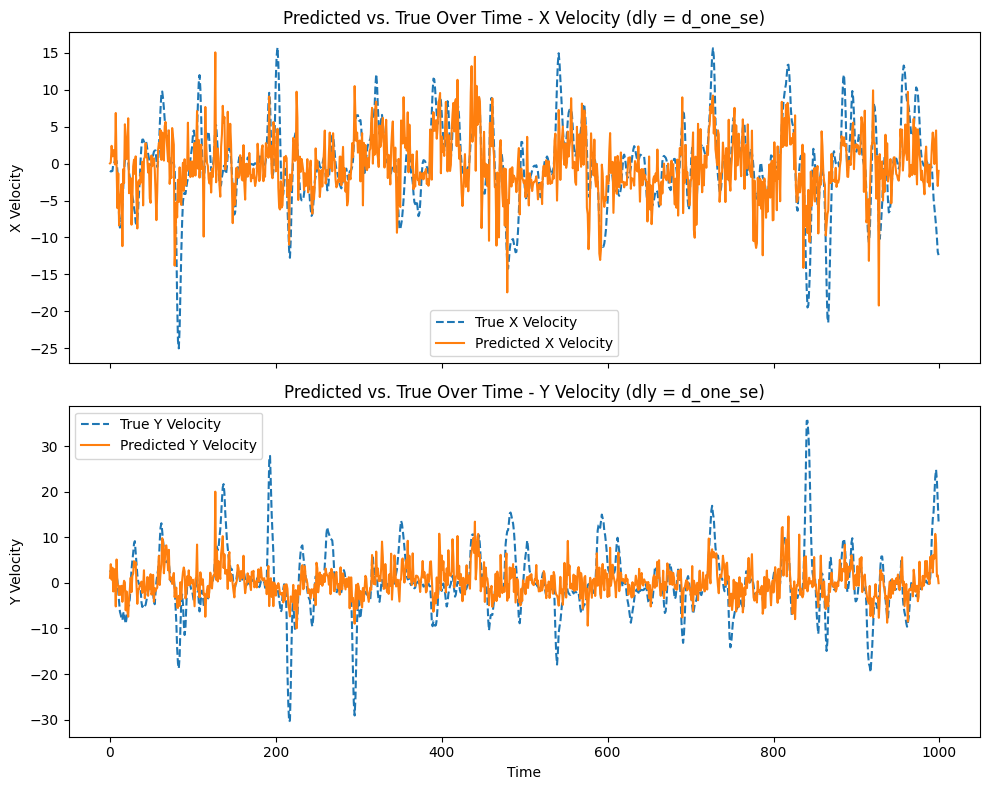

In [89]:
# TODO: Predicted and true values over time for dly=d_one_se visualization
import matplotlib.pyplot as plt

Xdly_test, ydly_test = create_dly_data(Xts, yts, dmax)

# Select the appropriate columns from the test set
X_test_final = Xdly_test[:, :d_one_se+1]

# Predict on the test set
y_pred_final = final_model.predict(X_test_final)

# Define the number of samples to visualize
num_samples = 1000

# Create subplots for X velocity and Y velocity
fig, axes = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# Plot X velocity over time
axes[0].plot(ydly_test[:num_samples, 0], label="True X Velocity", linestyle="dashed")
axes[0].plot(y_pred_final[:num_samples, 0], label="Predicted X Velocity")
axes[0].set_ylabel("X Velocity")
axes[0].set_title("Predicted vs. True Over Time - X Velocity (dly = d_one_se)")
axes[0].legend()

# Plot Y velocity over time
axes[1].plot(ydly_test[:num_samples, 1], label="True Y Velocity", linestyle="dashed")
axes[1].plot(y_pred_final[:num_samples, 1], label="Predicted Y Velocity")
axes[1].set_xlabel("Time")
axes[1].set_ylabel("Y Velocity")
axes[1].set_title("Predicted vs. True Over Time - Y Velocity (dly = d_one_se)")
axes[1].legend()

plt.tight_layout()
plt.show()


–\>